In [1]:
import cv2 as cv
import os
import IPython.display as ipd

import json

import numpy as np

import keras

from keras.preprocessing import image as kimage
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Imports for face alignment
# pip install imutils
# conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [3]:
# load keras model
model_number = 8
model = keras.models.load_model(f"./models/{model_number}_model.h5")

In [4]:
with open(f"models/{model_number}_model.json") as jf:
    mjson = json.load(jf)

In [5]:
# # Caricamento modello per il rilevamento di volti frontali
# CV Face detector
model_filename = 'C:/Users/gianc/Anaconda3/envs/dsim/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml'
face_detector = cv.CascadeClassifier(model_filename)

In [6]:
# DLIB Face detector fol alignment
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

In [7]:
# I didn't save the "class_indicices" field for some models...
if "class_indices" not in mjson:
    if model.output_shape[1] == 8:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "luca", "mamma", "papi", "umbe"])
        
    if model.output_shape[1] == 7:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "luca", "mamma", "papi"])
    if model.output_shape[1] == 6:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "mamma", "papi"])
    if model.output_shape[1] == 5:
        labels = np.array(["alinda", "cami",  "gian",
                           "mamma",  "papi",])
else:
    labels = np.array(mjson["class_indices"])

In [8]:
labels

array(['alinda', 'cami', 'gian', 'mamma', 'papi'], dtype='<U6')

In [9]:
mjson

{'mean': ['136.2209', '113.89987', '111.045746'],
 'std': ['57.325066', '54.512905', '54.977913'],
 'model_n': 8,
 'featurewise_center': True,
 'featurewise_std': True}

In [10]:
# ...should have decided what to save in the json from the start...
if model_number > 3:
    mu = np.array([float(e) for e in mjson["mean"]]).reshape(1,1,3)
    std = np.array([float(e) for e in mjson["std"]]).reshape(1,1,3)


if "fine_tuning" in mjson:
    if mjson["fine_tuning"] == "resnet":
        preprocess_function = resnet_v2.preprocess_input
    elif mjson["fine_tuning"] == "no":
        mu = np.array([float(e) for e in mjson["mean"]]).reshape(1,1,3)
        std = np.array([float(e) for e in mjson["std"]]).reshape(1,1,3)
        preprocess_function = lambda x : (x - mu)/std
else:
    if model_number <= 3:
        preprocess_function = resnet_v2.preprocess_input
    else:
        preprocess_function = lambda x : (x - mu)/std
        
    

# Test with webcam

In [11]:
def ranks(ar):
    return ar.argsort()[::-1]

In [12]:
def add_box(img, model, mu, std, labels, preprocessing, align, more_space=10):
    m = more_space
    
    fontColors = [(0,0,255), (255,160,0)]
    fontScale              = 2
    
    lineType               = 2
    font                   = cv.FONT_HERSHEY_PLAIN
    
    if img is not None:
        
        face = 0
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        if align:
            faces = detector(gray, 2)
        else:
            faces = face_detector.detectMultiScale(img[:,:,1])
        
        # -1::-1 because cv img is BGR, but we need RGB (check)
        img2 = img[:,:,::-1]
        
        for rect in faces:    
            
            
            if align:
                (x, y, w, h) = rect_to_bb(rect)
                img2 = fa.align(img2, gray, rect)
                # img2 = cv.resize(img2, (224, 224))

            else:
                (x, y, w, h) = rect
                img2 = img[(y-m):(y+h+m), (x-m):(x+w+m), ::-1]
                img2 = cv.resize(img2, (224, 224))
                
            img2 = preprocessing(img2)
                
            pred = model.predict(img2[np.newaxis,:,:,:])[0]            
            text = labels[np.argmax(pred)]
            top3 = labels[ranks(pred)][:2]
            conf3 = pred[ranks(pred)][:2]
            
            
            bottomLeftCornerOfText = (x-m,y-m-5)      
            fontColor              = fontColors[face]
            
            cv.rectangle(img,(x-m,y-m),(x+w+m,y+h+m),fontColor,2)
            cv.putText(img, text, bottomLeftCornerOfText,
                       font, fontScale, fontColor, lineType)
            
            for i in range(len(top3)):
                line = "{}: {}".format(top3[i], str(np.around(conf3[i]*100, decimals = 2))+"%")
                cv.putText(img, line, (10, 25+30*i+face*420), # this won't work for more than two faces
                           font, fontScale, fontColor, lineType)
            face += 1
            # this function would not work for more than two faces anyway
            if face > 1:
                break
        
    return img

In [13]:
def test_model(model, mu, std, labels, preprocessing, align=False):
    labels = np.array(labels)
    cap = cv.VideoCapture(0)
    while(True):
        
        r, frame = cap.read()
        
        try:
            frame = add_box(frame, model, mu, std, labels, preprocessing, align)
            cv.imshow('Video', frame)
            
        except Exception as e:
            print(e)
            pass

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
                        
    cap.release()
    cv.destroyAllWindows()

In [14]:
# Faster but if you tilt your head the prediction might be wrong or your head might not be detected
test_model(model, mu, std, labels, preprocess_function, align=False)

In [15]:
test_model(model, mu, std, labels, preprocess_function, align=True)

## Test single shot

In [16]:
def test_model_single_shot(model, mu, std, labels, preprocessing, align=False):
    cap = cv.VideoCapture(0)
    result, img = cap.read()
    cap.release()
    plt.figure(figsize=(14,7))
    plt.imshow(add_box(img, model, mu, std, labels, preprocessing, align)[:,:,::-1])

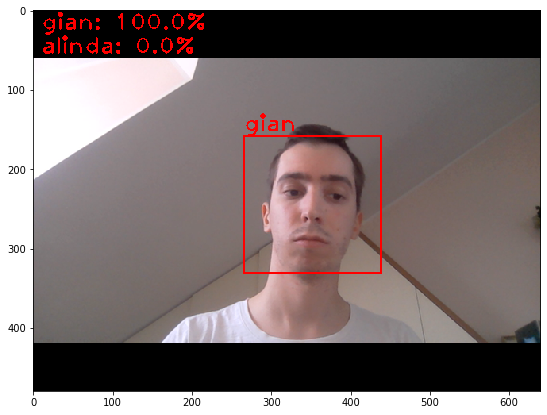

In [17]:
test_model_single_shot(model, mu, std, labels, preprocess_function, align=False)

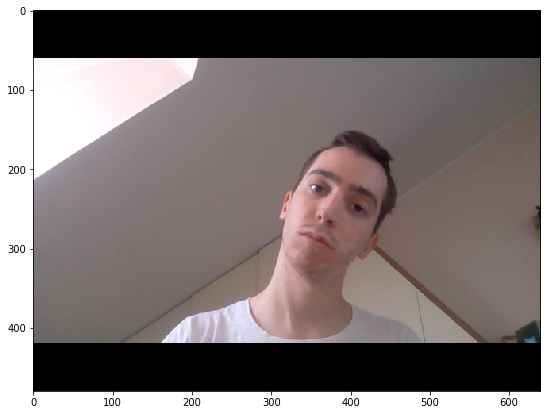

In [18]:
test_model_single_shot(model, mu, std, labels, preprocess_function, align=False)

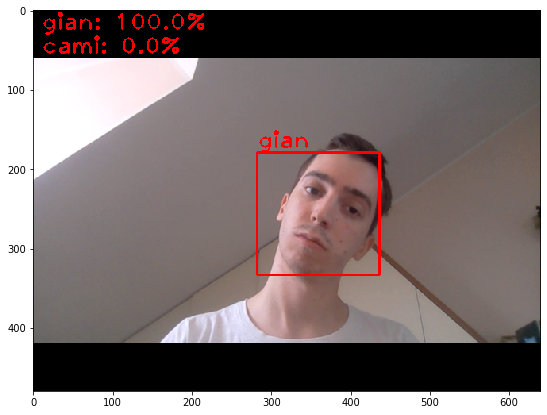

In [19]:
test_model_single_shot(model, mu, std, labels, preprocess_function, align=True)

# Test Directories

In [ ]:
labels

In [ ]:
# might make sense to test on some pictures not used during training
name = "gian"
basedir = "pictures_table/"+name
counts={}
for label in labels:
    counts[label] = 0
total = 1
for file in os.listdir(basedir):
    img = cv.imread(basedir+"/"+file)
    img2 = img[:,:,::-1]
    img2 = cv.resize(img2, (224, 224))
    img2 = (img2 - mu)/std

    pred = model.predict(img2[np.newaxis,:,:,:])
    
    text = labels[np.argmax(pred)]
    counts[text] += 1
    ipd.clear_output(wait=True)
    for i in counts.keys():
        print("{}: {}".format(i, counts[i]))
    print("\ntotal: ", total)
    print("accuracy: ", counts[name]/total)
    total += 1